In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [103]:
# Mary - propofolPuffTone
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# Mr Jones - propofolPuffTone
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/MrJones-Anesthesia-20160121-01.mat'
# Mary - propofolWakeup
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20170203-02.mat'
# Mary - propofolWakeup2
filename = '/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20161229-02.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 88.37 seconds)


## VAR

In [104]:
data_path = "../../__data__/VAR/Mary_Wakeup_2"
os.makedirs(data_path, exist_ok=True)
# areas = np.unique(electrode_info['area'])
# areas = ['vlPFC']
# unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
PCA_dim = -1
end_step = T - int(30/dt) # take off 30 seconds
# end_step = 5000
for window in [2.5]:
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
    stride = window
    results = {}
    
    for area in np.unique(electrode_info['area']):
        areas = [area]
        unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]

        data = lfp[:end_step, unit_indices]
        print(f"window = {window}, area = {area}")
        results[area] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, PCA_dim=PCA_dim, verbose=True)
        results[area]['end_step'] = end_step
        results[area]['data_sigma_norms'] = get_data_sigma_norms(data, dt, window, stride, verbose=True)
        del data
    
    save(results, os.path.join(data_path, f"results_window_{window}_stride_{stride}_PCA_dim_{PCA_dim}"))

window = 2.5, area = 7b


  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

window = 2.5, area = CPB


  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

window = 2.5, area = FEF


  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

window = 2.5, area = Thal


  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

window = 2.5, area = vlPFC


  0%|          | 0/2980 [00:00<?, ?it/s]

  0%|          | 0/2980 [00:00<?, ?it/s]

# Plotting

In [108]:
session_info['eyesClose'], session_info['eyesOpen']

(array([486.63973333, 502.15966667]), 6178.1640333333335)

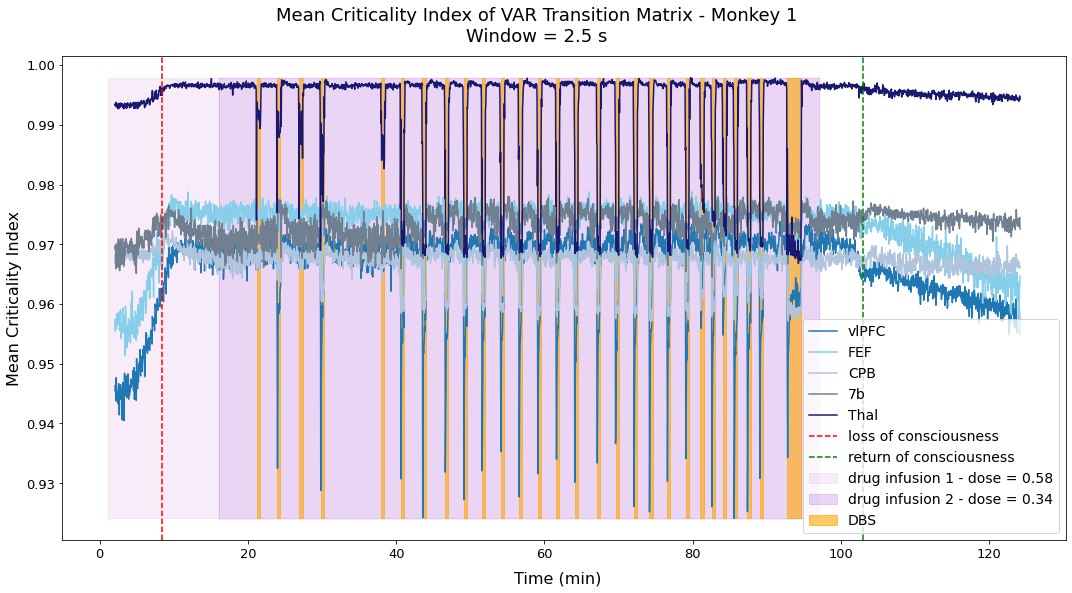

In [115]:
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()

window = 2.5
stride = window
results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

min_val = np.Inf
max_val = -np.Inf

start_ind = 50
end_ind = len(results[area]['eigs'])

if 'Wakeup' in data_path:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
else:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]

for area, c in areas_colors:
# for area, c in [('vlPFC', 'C0')]:
    start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
    criticality_inds = results[area]['eigs'].mean(axis=1)
    
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()

ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

if np.sum(session_info['eyesOpen']) < 10:
    plt.axvline(session_info['eyesClose'][0]/60, linestyle='--', c='red', label="loss of consciousness")
    plt.axvline(session_info['eyesClose'][1]/60, linestyle='--', c='green', label="return of consciousness")
else:
    plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
    plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")


if 'Wakeup' in data_path:
    dbs_bool = np.zeros(len(criticality_inds))
    for i, (t_on, t_off, timing_type) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'])):
        if timing_type == 'train':
            dbs_bool[int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1
            
    ax.fill_between(start_times, min_val, max_val, where=dbs_bool, color='orange', alpha=0.6, label='DBS')
    

    
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()

## Plot DBS

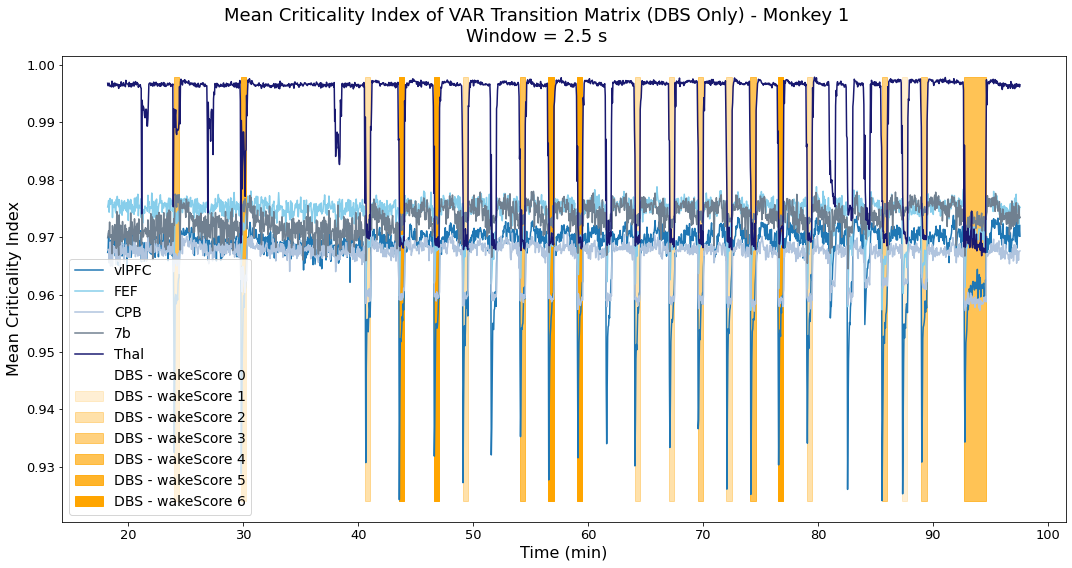

In [114]:
fig = plt.figure(figsize=(15, 8))

window = 2.5
stride = window
results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

min_val = np.Inf
max_val = -np.Inf
start_ind = int((trial_info['dbs_stimOn'][0] - 180)/stride)
end_ind = int(([t for t, typ in zip(trial_info['dbs_stimOff'], trial_info['dbs_timingType']) if typ == 'train'][-1] + 180)/stride)

if 'Wakeup' in data_path:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
else:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]

for area, c in areas_colors:
# for area, c in [('vlPFC', 'C0')]:
    start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
    criticality_inds = results[area]['eigs'].mean(axis=1)
    start_times = start_times[start_ind:end_ind]
    criticality_inds = criticality_inds[start_ind:end_ind]
    plt.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()


if 'Wakeup' in data_path:
    dbs_bool = np.zeros((7, len(criticality_inds)))
    for i, (t_on, t_off, timing_type, score) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'], trial_info['dbs_wakeScore'])):
        if timing_type == 'train':
            score = int(score)
            dbs_bool[score, int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1
            
    for score in range(7):
        plt.fill_between(start_times, min_val, max_val, where=dbs_bool[score], color='orange', alpha=score/6, label=f'DBS - wakeScore {score}')
    

    
plt.legend(fontsize=14)        
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Mean Criticality Index', fontsize=16)
plt.tick_params(labelsize=13)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix (DBS Only) - Monkey 1\nWindow = 2.5 s", fontsize=18)
plt.tight_layout()
plt.show()

## Plot MSE

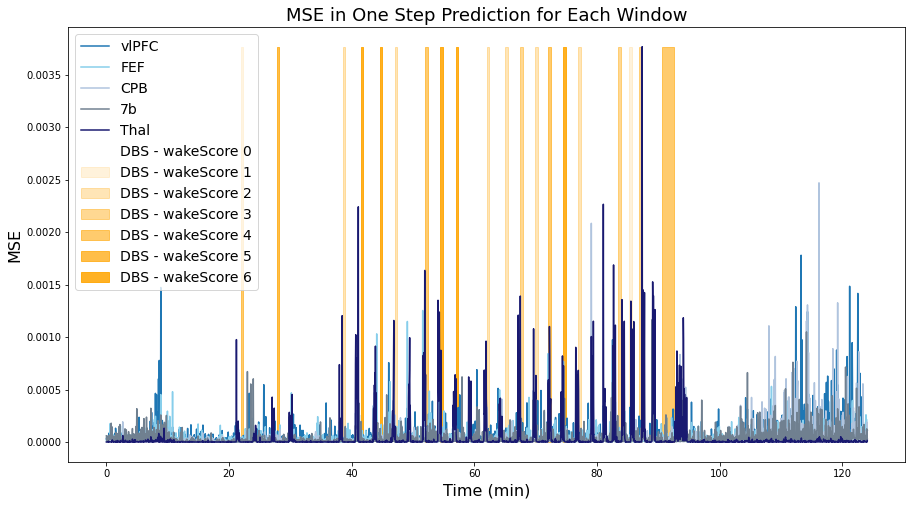

In [117]:
plt.figure(figsize=(15, 8))
min_val = np.Inf
max_val = -np.Inf
start_ind = 50
end_ind = len(results[area]['mse'])
if 'Wakeup' in data_path:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]
else:
    areas_colors = [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]

for area, c in areas_colors:
    start_times = (np.arange(results[area]['eigs'].shape[0])*stride/60)[:-1]
    plt.plot(start_times, results[area]['mse'], c=c, label=area)
    
    if results[area]['mse'].min() < min_val:
        min_val = results[area]['mse'].min()
    if results[area]['mse'].max() > max_val:
        max_val = results[area]['mse'].max()
    
if 'Wakeup' in data_path:
    dbs_bool = np.zeros((7, len(results[area]['mse'])))
    for i, (t_on, t_off, timing_type, score) in enumerate(zip(trial_info['dbs_stimOn'], trial_info['dbs_stimOff'], trial_info['dbs_timingType'], trial_info['dbs_wakeScore'])):
        if timing_type == 'train':
            score = int(score)
            dbs_bool[score, int(t_on/stride) - start_ind:int(t_off/stride) - start_ind] = 1
            
    for score in range(7):
        plt.fill_between(start_times, min_val, max_val, where=dbs_bool[score], color='orange', alpha=score/7, label=f'DBS - wakeScore {score}')
    
plt.xlabel("Time (min)", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.title("MSE in One Step Prediction for Each Window", fontsize=18)
plt.legend(fontsize=14)
plt.show()